In [39]:
import pandas as pd
import numpy as np
from scipy.special import gamma
from hurst import compute_Hc, random_walk
from statsmodels.tsa.stattools import acf
from math import log
from statsmodels.tsa.ar_model import AutoReg
def prepare_data(path):
    df = pd.read_csv(path)
    df.columns = ['Date_vix']
    df['Date'] = df['Date_vix'].apply(lambda x: x[0:8])
    df['vix'] = df['Date_vix'].apply(lambda x: x[9:])
    df['vix'] = df['vix'].apply(lambda x: str.replace(x, ' ', ''))
    df['vix'] = df['vix'].apply(lambda x: 0.0 if x == '.' else x)
    df['vix'] = df['vix'].astype(float)
    df['log_vix'] = np.log(df['vix'])
    df['Date'] = pd.to_datetime(df['Date'])
    return df


def obtain_train(df_ori):
    #

    # value_first = df_ori['residual'].values[0]
    # df_ori['residual'] = df_ori['residual'] - value_first
    # df_ori['residual_mean'] =  df_ori['residual'].mean()
    # df_ori['lr'] = 2 * np.linspace(0, 1, df_ori.shape[0]) * df_ori['residual'].mean()
    df_ori['x'] = df_ori['residual'] # - df_ori['lr']
    # df_ori['x'] = df_ori['residual']
    df_ori['y'] = df_ori['x'].diff()
    # print("value_first in obtain_train is ", value_first)
    
    return df_ori,0 # value_first


def obtain_train_ar(df, n, date):
    df_ori = df[df['Date'] >= date][0:n].reset_index(drop=True)
    return df_ori

def obtain_gamma(value):
    value_ = np.power(gamma((value + 1) / 2), 2) / gamma(value + 0.5)
    return value_ / np.sqrt(np.pi)


def obtain_lambda(target):
    left = 0
    right = 3
    mid = (left + right) / 2
    while abs(obtain_gamma(mid) - target) > 10 ** -8:
        if obtain_gamma(mid) > target:
            left = mid
            mid = (left + right) / 2
        elif obtain_gamma(mid) < target:
            right = mid
            mid = (left + right) / 2
        else:
            return mid
    return mid

def obtain_residual_by_ar(df_):
    acf_params_ = acf(df_['log_vix'],nlags=50)
    model_ = AutoReg(df_['log_vix'], lags=3).fit()
    predict = model_.predict()
    print("predict is ", predict)
    df_['ar_predict'] = predict.values

    df_['residual'] = df_['log_vix']-df_['ar_predict']

    forecast  =model_.forecast(1)
    return model_.params,df_, forecast


def objective_function(x, a,b):
    err = []
    for i in range(len(a)-1):
        err.append(np.power(a[i+1]-x[0]*a[i]-x[1]*b[i+1]-x[2],2)) # 可以加入对过去的多个依赖
    # print(err)
    return np.sum(err) #np.sqrt(np.sum(err))

from scipy.optimize import minimize, LinearConstraint

In [40]:
# def obtain_true(df,n,date):
#     df_ori = df[df['Date'] >= date][0:n].reset_index(drop=True)
#     value_first = df_ori['log_vix'].values[0]
#     df_ori['log_vix'] = df_ori['log_vix'] - value_first
#
#     return df_ori,value_first

def obtain_true_ar(df,n,date):
    df_ori = df[df['Date'] >= date][0:n].reset_index(drop=True)
    return df_ori

In [41]:
# Loss function definition
def hmse(y_true,y_pred):
    ratio = y_pred/y_true
    return np.mean(np.power((ratio[abs(ratio)<200]-1),2))

def hmae(y_true,y_pred):
    ratio = y_pred/y_true
    return np.mean(abs(ratio[abs(ratio)<200]-1))

def mse(y_true,y_pred):
    return np.mean(np.power(np.abs(y_true-y_pred),2))

def mae(y_true,y_pred):
    return np.mean(np.abs(y_true-y_pred))

In [42]:
def calculate_aic(n, mse, num_params):
    """
    compute aic
    :param n:
    :param mse:
    :param num_params:
    :return:
    """
    aic = n * log(mse) + 2 * num_params
    return aic


def calculate_bic(n, mse, num_params):
    """
    compute bic
    :param n:
    :param mse:
    :param num_params:
    :return:
    """
    bic = n * log(mse) + num_params * log(n)
    return bic



In [43]:
def obtain_v(data,H):
    n = data.shape[0]
    S = np.zeros([n+2,n+2])

    for i in range(1,n+2):
        for j in range(1,n+2):
            S[i][j] = (np.power(i,2*H)+ np.power(j,2*H) -np.power(np.power(j-i,2),H))/(2*(n+1)**(2*H))
    S = S[1:,1:]
    A = S[0:n,0:n]
    A_ = np.linalg.inv(A)
    B_T = S[-1,0:n]
    print("A shape is ", A.shape)
    print("B_T shape is ", B_T.shape)
    print("data shape is ", data.shape)
    print("data['u'].values[-1] = ", data['u'].values[-1],np.dot(B_T.reshape(1,-1),A_))
    print("debug"*5,np.dot(np.dot(B_T.reshape(1,-1),A_),data['u'].values.reshape(-1,1))[0])
    v = np.dot(np.dot(B_T.reshape(1,-1),A_),data['u'].values.reshape(-1,1))[0]-data['u'].values[-1]
    u_hat = np.dot(np.dot(B_T.reshape(1,-1),A_),data['u'].values.reshape(-1,1))[0]
    return v,u_hat

In [44]:
def obtain_params(data):
    log_vix = data['log_vix'].values
    z_i = data['z_i'].values
    res = minimize(
    objective_function,
    x0=0.5 * np.random.random(3),
    args=(log_vix,z_i),
)
    return res

In [45]:
# def predict_self(data,v,x,lambda_):
#     z = np.sign(v)*np.power(abs(v),lambda_)
#     result = data['y'].values[-1]*x[0]+z*x[1]+x[2]    #####
#     return result

def compute_z(v,lambda_):
    return np.sign(v)*np.power(abs(v),lambda_)


In [1]:
def main(date, n = 500):
    df = prepare_data('./data/VIXdata.txt')
    df_ori = df[df['Date'] >= date][0:n].reset_index(drop=True)
    params_ar,df_ori, forecast = obtain_residual_by_ar(df_ori)
    forecast = forecast.values
    print("forecast is ", forecast)
    print("df_ori after obtain_residual_by_ar is ", df_ori.head(30))
    df_ori = df_ori.dropna()
    df_ori,value_first = obtain_train(df_ori)
    df_ = df_ori.dropna()
    print("debug here df_", df_.head())

    df_['abs_y'] = np.abs(df_['y'])
    df_['squared'] = df_['y']*df_['y']
    R1n = df_['abs_y'].mean()
    R2n = df_['squared'].mean()
    lambda_ = obtain_lambda(R1n*R1n/R2n)
    print("lambda_ =", lambda_)
    df_['y_tilde'] = np.sign(df_['y'])*np.power(df_['abs_y'],1/lambda_) #+1/lambda_
    df_['u'] = np.cumsum(df_['y_tilde'])
    df_['z_i'] = df_[['y','y_tilde']].apply(lambda x:np.sign(x[0])*np.power(abs(x[1]),lambda_),axis=1)
    series = df_['u'].values  # create a random walk from random changes
    print("series is ", series)
    # Evaluate Hurst equation
    H, c, data = compute_Hc(series, kind='random_walk', simplified=True)
    v,u_hat = obtain_v(df_,H)
    print("v = ", v)
    u_tmp = np.sign(df_['u'].values[-1])* np.power(np.abs(df_['u'].values[-1]),lambda_)

    z = compute_z(v,lambda_)
    # res = obtain_params(df_)
    # x = res.x
    print("z = ",z)
    v_i = df_['log_vix'].values[-1] #volatility past value
    ar_i = df_['ar_predict'].values[-1] #ar approximte last value
    result = forecast -(z)+0*(v_i-(ar_i)) # predict_self(df_,v,x,lambda_)   ########


    df_true = df[df['Date'] >= date][0:n+1].reset_index(drop=True)
    date_ = df_true['Date'].values[-1]
    true_value = df_true['log_vix'].values[-1]
    print("value_first is in main:",value_first)
    # print("2*df_['residual_mean'].values[-1] is in main:",2*df_['residual_mean'].values[-1])
    # log_vix_t_1 = df_true['log_vix'].values[-2]+value_first_
    # print(log_vix_t_1)
    # print(x,log_vix_t_1,result[0])
    # return [forecast, result+2*df_['residual_mean'].values[-1]+value_first, date_,true_value,H,lambda_],df_,value_first
    return [forecast[0], result[0], date_,true_value,H,lambda_,value_first,z[0],u_tmp,u_hat[0]],df_,value_first

# 1. Compute the fGn $Z_t$



In [2]:
df = prepare_data('./data/VIXdata.txt')
n = 150
date_list = [str.replace(str(x),'-','')[:8] for x in  df[df['Date']>='2012-02-01']['Date'].values[0:] ]
result = []
for date in date_list:
    result_,_,a_ = main(date,n=n)
    result.append(result_)
result

NameError: name 'prepare_data' is not defined

In [121]:
from sklearn.metrics import mean_absolute_error,r2_score

In [122]:
df_result = pd.DataFrame(result,columns=['ar','zhu','date','true','H','lambda_','value_first','z','u_tmp','u_hat'])
df_result

,ar,zhu,date,true,H,lambda_,value_first,z,u_tmp,u_hat
0,2.497440,2.565566,2017-09-06,2.453588,0.281101,1.605137,0,-0.023768,0.095480,0.134137
1,2.435477,2.397657,2017-09-07,2.446685,0.288216,1.594914,0,0.014595,0.000619,0.080362
2,2.446413,2.452105,2017-09-08,2.494857,0.284759,1.589249,0,-0.001161,0.012125,0.048033
3,2.483645,2.503488,2017-09-11,2.373044,0.292509,1.595665,0,-0.006285,0.203395,0.326881
4,2.379148,2.343438,2017-09-12,2.358965,0.313433,1.582539,0,0.013831,-0.017947,-0.011965
...,...,...,...,...,...,...,...,...,...,...
195,2.498255,2.499523,2018-06-15,2.483239,0.467614,1.608658,0,0.000441,0.588604,0.727512
196,2.501502,2.504682,2018-06-18,2.510412,0.466509,1.599270,0,-0.000251,0.886766,0.922006
197,2.520961,2.525755,2018-06-19,2.591516,0.439822,1.612429,0,-0.000835,0.681505,0.776021
198,2.592980,2.596165,2018-06-20,2.548664,0.482598,1.624097,0,-0.000253,1.704344,1.382502


# 2. Forecasts result
## 2.1 Plot the forecasts

<AxesSubplot:>

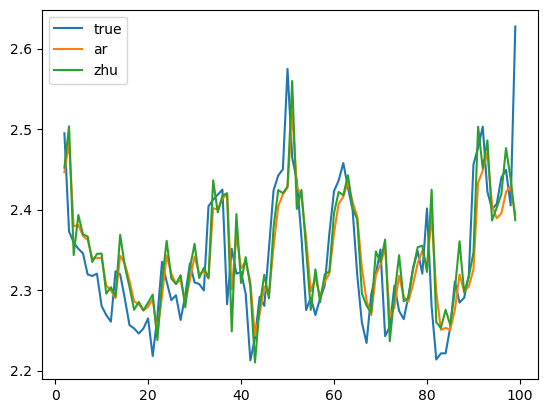

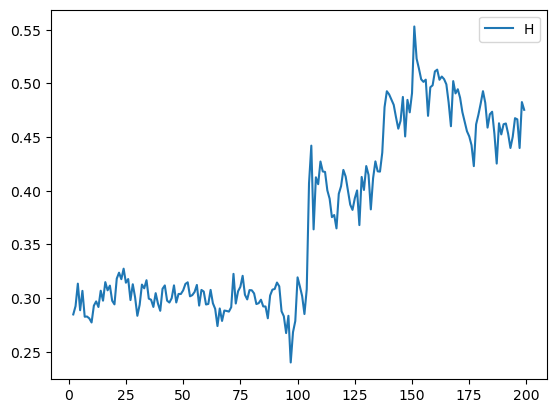

In [123]:
df_result[(df_result.index<100)&(df_result.index>1)][['true','ar','zhu']].plot()
df_result[(df_result.index<200)&(df_result.index>1)][['H']].plot()

## 2.2 Loss functions

In [124]:
sst=1 # start point
eed=200 # end point

In [125]:
# HMSE, HMAE    Mine
hmse(df_result['true'].values[sst:eed],df_result['zhu'].values[sst:eed]),hmae(df_result['true'].values[sst:eed],df_result['zhu'].values[sst:eed])

(0.0010775979831621416, 0.02253693434064636)

In [126]:
# HMSE, HMAE      AR
hmse(df_result['true'].values[sst:eed],df_result['ar'].values[sst:eed]),hmae(df_result['true'].values[sst:eed],df_result['ar'].values[sst:eed])

(0.0010834095540463743, 0.022057000239701995)

In [127]:
# MSE, MAE        Mine
mse(df_result['true'].values[sst:eed],df_result['zhu'].values[sst:eed]), mae(df_result['true'].values[sst:eed],df_result['zhu'].values[sst:eed])

(0.009530907655861297, 0.061029398530849786)

In [128]:
# MSE, MAE         AR
mse(df_result['true'].values[sst:eed],df_result['ar'].values[sst:eed]), mae(df_result['true'].values[sst:eed],df_result['ar'].values[sst:eed])

(0.009869640167685092, 0.05996901783362187)

In [129]:
# R^2               Mine
r2 = r2_score(df_result['true'].values[sst:eed],df_result['zhu'].values[sst:eed])
r2 

0.8969036094728993

In [130]:
# R^2                AR
r2 = r2_score(df_result['true'].values[sst:eed],df_result['ar'].values[sst:eed])
r2 

0.893239519904081

In [79]:
from sklearn.linear_model import LinearRegression

In [115]:
df_result['H'].mean()

0.3716134468560098

# Linear Reg of $\theta$

In [88]:
reg_model = LinearRegression()

reg_model.fit(df_result[['z']].values,df_result['true']-df_result['ar'])

LinearRegression()

In [89]:
reg_model.coef_

array([-2.76169388])

In [118]:
reg_model.intercept_

-0.002486691453829662